In [32]:
import scanpy as sc, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [3]:
adata = sc.read_h5ad("bipolar_raw.h5ad")

### Check for class imbalance

In [ ]:
df = adata.obs[['cell_type', 'age']].copy()
count_df = df.groupby(['cell_type', 'age'], observed = True).size().unstack(fill_value=0)
percentage_df = count_df.div(count_df.sum(axis=1), axis=0) * 100

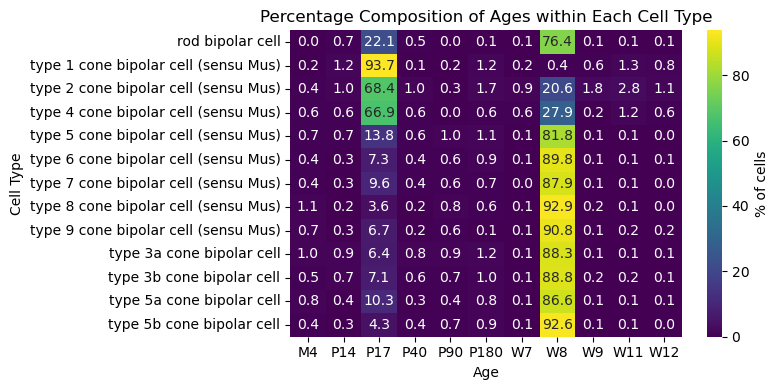

In [12]:
plt.figure(figsize=(8, 4))
sns.heatmap(percentage_df, annot=True, fmt=".1f", cmap="viridis", cbar_kws={'label': '% of cells'})
plt.title("Percentage Composition of Ages within Each Cell Type")
plt.ylabel("Cell Type")
plt.xlabel("Age")
plt.tight_layout()
plt.show()

In [15]:
percentage_df.var(axis=1)

cell_type
rod bipolar cell                        541.158212
type 1 cone bipolar cell (sensu Mus)    787.687221
type 2 cone bipolar cell (sensu Mus)    420.680869
type 4 cone bipolar cell (sensu Mus)    434.646465
type 5 cone bipolar cell (sensu Mus)    597.754036
type 6 cone bipolar cell (sensu Mus)    720.215059
type 7 cone bipolar cell (sensu Mus)    690.386880
type 8 cone bipolar cell (sensu Mus)    774.468753
type 9 cone bipolar cell (sensu Mus)    737.201013
type 3a cone bipolar cell               692.985028
type 3b cone bipolar cell               702.625210
type 5a cone bipolar cell               669.601119
type 5b cone bipolar cell               768.726966
dtype: float64

Conclusion: Choose type 5a cone bipolar cell because it offers a balance between class imbalance and cluster size

### Training starts!

In [16]:
sub_adata = adata[adata.obs["cell_type"] == "type 5a cone bipolar cell"].copy()

In [17]:
sub_adata

AnnData object with n_obs × n_vars = 18842 × 32034
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'pANN', 'sampleid', 'age', 'gender', 'reference', 'accession', 'sample_note', 'subclass_label', 'author_cell_type', 'development_stage_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_type', 'library_platform', 'cell_type_ontology_term_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'default_embedding', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_scVI', 'X_umap'

In [18]:
age_counts = sub_adata.obs["age"].value_counts()

In [20]:
max_other = age_counts.drop(["W8", "P17"], errors="ignore").max()
# Step 4: Downsample W8 and P17 to max_other
keep_indices = []
for age, count in age_counts.items():
    idx = sub_adata.obs[sub_adata.obs["age"] == age].index
    if age in ["W8", "P17"] and count > max_other:
        sampled = np.random.choice(idx, max_other, replace=False)
    else:
        sampled = idx
    keep_indices.extend(sampled)

# Step 5: Subset to balanced data
balanced_adata = sub_adata[keep_indices].copy()

In [24]:
# Step 6: Prepare data
X = balanced_adata.X.toarray() if not isinstance(balanced_adata.X, np.ndarray) else balanced_adata.X
y = balanced_adata.obs["age"].astype(str)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Step 7: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)

# Step 8: Train XGBoost (GPU)
clf = XGBClassifier(
    tree_method='hist',
    device = 'cuda',
    eval_metric='mlogloss'
)
clf.fit(X_train, y_train)

# Step 9: Evaluate
y_pred = clf.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

          M4       0.87      0.87      0.87        31
         P14       0.92      0.92      0.92        13
         P17       1.00      0.94      0.97        31
        P180       0.81      0.87      0.84        30
         P40       0.77      0.83      0.80        12
         P90       0.93      0.81      0.87        16
         W11       0.33      0.60      0.43         5
         W12       1.00      0.33      0.50         3
          W7       0.67      0.40      0.50         5
          W8       0.81      0.91      0.85        32
          W9       0.00      0.00      0.00         3

    accuracy                           0.84       181
   macro avg       0.74      0.68      0.69       181
weighted avg       0.84      0.84      0.83       181



/home/mr_wick/miniconda3/envs/omics_python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mr_wick/miniconda3/envs/omics_python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mr_wick/miniconda3/envs/omics_python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

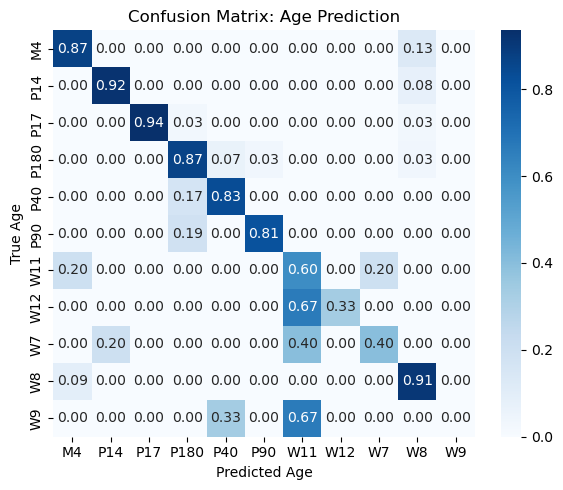

In [31]:
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=np.unique(y_test_labels), normalize = "true")

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=np.unique(y_test_labels),
            yticklabels=np.unique(y_test_labels))
plt.xlabel("Predicted Age")
plt.ylabel("True Age")
plt.title("Confusion Matrix: Age Prediction")
plt.tight_layout()
plt.show()

### Interpretation

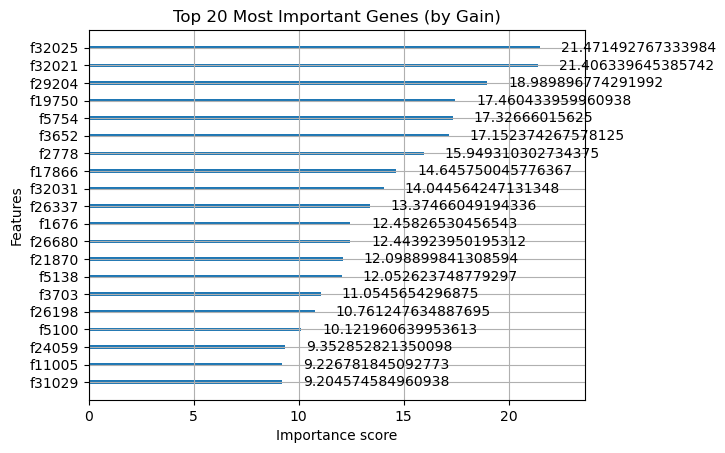

In [33]:
plot_importance(clf, max_num_features=20, importance_type='gain')
plt.title("Top 20 Most Important Genes (by Gain)")
plt.show()

In [40]:
# Get feature importance as dictionary
importance_dict = clf.get_booster().get_score(importance_type='gain')

# Map to gene names
feature_names = balanced_adata.var_names.tolist()  # or whatever AnnData you used
mapped_importance = {feature_names[int(k[1:])]: v for k, v in importance_dict.items()}

# Convert to DataFrame for ranking
importance_df = pd.DataFrame(mapped_importance.items(), columns=['Gene', 'Importance']).sort_values(by='Importance', ascending=False)

importance_df.head(20)  # Top 20 genes

,Gene,Importance
881,ENSMUSG00000064358,21.471493
877,ENSMUSG00000064357,21.406340
792,ENSMUSG00000029810,18.989897
360,ENSMUSG00000029004,17.460434
130,ENSMUSG00000039488,17.326660
58,ENSMUSG00000022956,17.152374
20,ENSMUSG00000049470,15.949310
291,ENSMUSG00000060743,14.645750
886,ENSMUSG00000065947,14.044564
656,ENSMUSG00000023971,13.374660


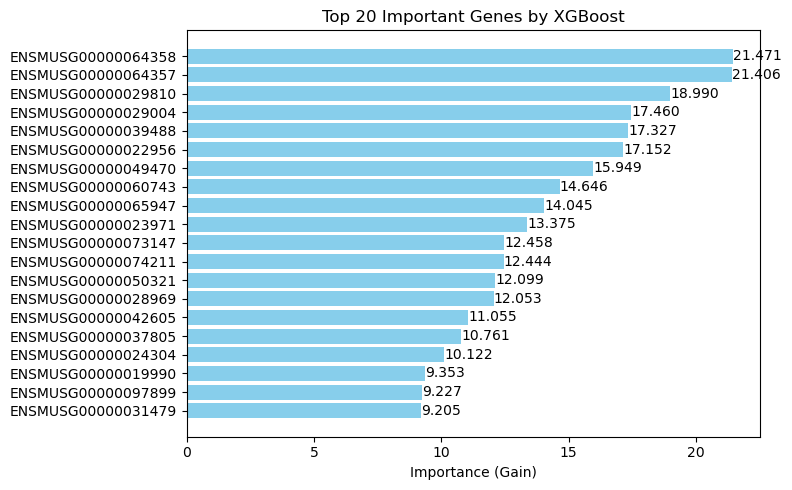

In [42]:
plt.figure(figsize=(8, 5))
df_sub = importance_df.head(20)
bars = plt.barh(df_sub['Gene'], df_sub['Importance'], color='skyblue')
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2, f'{width:.3f}', va='center')
plt.gca().invert_yaxis()
plt.xlabel('Importance (Gain)')
plt.title('Top 20 Important Genes by XGBoost')
plt.tight_layout()
plt.show()